In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

import os

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

import seaborn as sns
colors = ['lightcoral', 'sandybrown', 'orange', 'olive', 'darkseagreen', 'dodgerblue', 'mediumpurple', 'hotpink']
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(14,9)})
sns.set(rc={'grid.alpha':0.75})
# sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

#### This notebook is for exploring time series analysis, nothing concreate comes from this notebook. For more thorough analysis, check the forecast notebooks.

## Get Data - Folsom & [ BoulderCreek Path, South St., Pine]

In [4]:
path_notebook = os.path.abspath('analysis_time_series.ipynb')
dirname = os.path.dirname(path_notebook)

# Folsom & BoulderCreek Path START DATE: 8/9/2011 - Friday
# df_folsom_bouldercreek = pd.read_csv(os.path.join(dirname, 'data_cleaned/folsom_bouldercreek.csv'))
# df_folsom_bouldercreek['date'] = pd.to_datetime(df_folsom_bouldercreek['date'])

# Folsom & South St. START DATE: 7/20/2015 - Monday
start_year = 2016
end_year = 2019

df_folsom_south = pd.read_csv(os.path.join(dirname, 'data_cleaned/folsom_south.csv'))

df_folsom_south['date'] = pd.to_datetime(df_folsom_south['date'])

# Add day of the week feature 0 - Monday, 1 - Tuesday...
df_folsom_south['weekday'] = df_folsom_south['date'].dt.dayofweek
df_folsom_south.set_index('date', inplace=True)

df_folsom_south = df_folsom_south[(df_folsom_south.index.year >= start_year)]

# Folsom & Pine START DATE: 7/20/2015 - Monday
# df_folsom_pine = pd.read_csv(os.path.join(dirname, 'data_cleaned/folsom_pine.csv'))
# df_folsom_pine['date'] = pd.to_datetime(df_folsom_pine['date'])


## Uncomment to view table structures
# print('Folsom & Boulder Creek Path')
# print(df_folsom_bouldercreek)
# print('Folsom & South St.')
# print(df_folsom_south)
# print('Folsom & Pine')
# print(df_folsom_pine)

#########################################################################################################
# Weather Data START DATE: 1/1/2011 - Saturday
df_weather = pd.read_csv(os.path.join(dirname, 'data_cleaned/weather_daily.csv'))
df_weather['date'] = pd.to_datetime(df_weather['date'])

# -998 is used to represent missing data
df_weather = df_weather[(df_weather.tmin != -998) | (df_weather.tmax != -998)]

# -999.00, -999.0, and -999 represent a trace of precipitation(less than 0.01 inches)
# replace with 0.01
df_weather['precip'].replace(to_replace = -999.00, value = 0.01, inplace=True)
df_weather['snow'].replace(to_replace = -999.0, value = 0.01, inplace=True)
df_weather['snowcover'].replace(to_replace = -999, value = 0.1, inplace=True)

## Uncomment to view table structure
# df_weather

### Slicing

In [5]:
def reset_index(df):
    df = df.reset_index()
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    return(df)

##########
# days_folsom_bouldercreek = df_folsom_bouldercreek.groupby(pd.Grouper(key='date', freq='d'))['total'].sum()
# weeks_folsom_bouldercreek = df_folsom_bouldercreek.groupby(pd.Grouper(key='date', freq='7d'))['total'].sum()
# months_folsom_bouldercreek = (df_folsom_bouldercreek.groupby(pd.Grouper(key='date', freq='M'))['total'].sum())

# days_folsom_bouldercreek = reset_index(days_folsom_bouldercreek, 'count_day')
# days_folsom_bouldercreek
# weeks_folsom_bouldercreek = reset_index(weeks_folsom_bouldercreek)
# months_folsom_bouldercreek = reset_index(months_folsom_bouldercreek)

##########
days_folsom_south = df_folsom_south.groupby([pd.Grouper(freq='d'), 'weekday'])['total'].sum()
weeks_folsom_south = df_folsom_south.groupby([pd.Grouper(freq='W-MON')])['total'].sum()
months_folsom_south = df_folsom_south.groupby([pd.Grouper(freq='M')])['total'].sum()

days_folsom_south = reset_index(days_folsom_south)
weeks_folsom_south = reset_index(weeks_folsom_south)
months_folsom_south = reset_index(months_folsom_south)

##########
# days_folsom_pine = df_folsom_pine.groupby(pd.Grouper(key='date', freq='d'))['total'].sum()
# weeks_folsom_pine = df_folsom_pine.groupby(pd.Grouper(key='date', freq='7d'))['total'].sum()
# months_folsom_pine = df_folsom_pine.groupby(pd.Grouper(key='date', freq='M'))['total'].sum()

# days_folsom_pine = reset_index(days_folsom_pine, 'count_day')
# weeks_folsom_pine = reset_index(weeks_folsom_pine)
# months_folsom_pine = reset_index(months_folsom_pine)

### Merging

In [6]:
# Remove weather data to line up with bike count data
south_weather = df_weather[(df_weather['date'].dt.year >= start_year)]
south_weather = south_weather[(south_weather['date'].dt.year <= end_year)]
south_weather.set_index('date', inplace=True)

# Join
days_FS = days_folsom_south.join(south_weather, how='left')

# Drop NA
days_FS.dropna(axis=0, how='any', inplace=True)

print('Raw Data Set And Daily Grouping and Weather:')
print(df_folsom_south.head(5))
print(days_FS.head(5))

Raw Data Set And Daily Grouping and Weather:
                     nb  sb  total  weekday
date                                       
2016-01-01 00:00:00   0   0      0        4
2016-01-01 00:15:00   0   0      0        4
2016-01-01 00:30:00   0   0      0        4
2016-01-01 00:45:00   0   0      0        4
2016-01-01 01:00:00   0   0      0        4
            weekday  total  tmax  tmin  precip  snow  snowcover
date                                                           
2016-01-01        4     80  39.0   3.0     0.0   0.0        3.0
2016-01-02        5    196  46.0  15.0     0.0   0.0        3.0
2016-01-03        6    726  50.0  19.0     0.0   0.0        3.0
2016-01-04        0    627  45.0  21.0     0.0   0.0        2.0
2016-01-05        1    142  51.0  23.0     0.0   0.0        2.0


In [7]:
print(df_folsom_south.isna().values.any())
print(days_FS.isna().values.any())

False
False


### Plotting

In [8]:
days_FS.describe()

,weekday,total,tmax,tmin,precip,snow,snowcover
count,1368.000000,1368.000000,1368.000000,1368.000000,1368.000000,1368.000000,1368.000000
mean,3.004386,623.690789,67.602339,38.676170,0.055585,0.226842,0.406944
std,2.001092,310.067563,17.942232,15.111232,0.181731,1.157688,1.366043
min,0.000000,0.000000,8.000000,-10.000000,0.000000,0.000000,0.000000
25%,1.000000,396.750000,54.000000,28.000000,0.000000,0.000000,0.000000
50%,3.000000,613.000000,69.000000,39.000000,0.000000,0.000000,0.000000
75%,5.000000,817.250000,83.000000,52.000000,0.010000,0.000000,0.000000
max,6.000000,1806.000000,100.000000,72.000000,3.110000,16.400000,14.000000


In [9]:
days_FS.corr()

,weekday,total,tmax,tmin,precip,snow,snowcover
weekday,1.000000,-0.197146,0.010806,-0.001767,-0.028069,0.003805,0.009596
total,-0.197146,1.000000,0.418046,0.364129,-0.194501,-0.200102,-0.216516
tmax,0.010806,0.418046,1.000000,0.900765,-0.175934,-0.299295,-0.459049
tmin,-0.001767,0.364129,0.900765,1.000000,-0.047055,-0.238432,-0.447708
precip,-0.028069,-0.194501,-0.175934,-0.047055,1.000000,0.604477,0.368260
snow,0.003805,-0.200102,-0.299295,-0.238432,0.604477,1.000000,0.694282
snowcover,0.009596,-0.216516,-0.459049,-0.447708,0.368260,0.694282,1.000000


Text(0, 0.5, 'Bike Count')

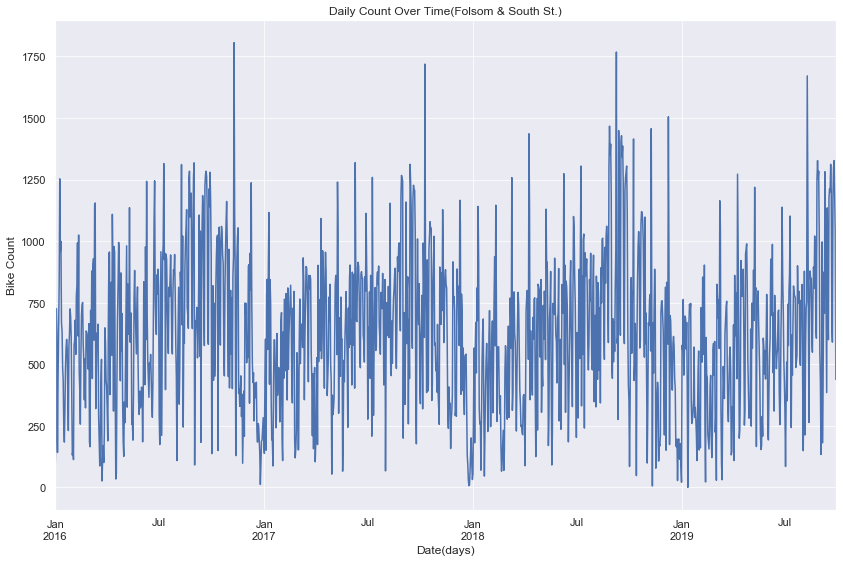

In [11]:
days_FS['total'].plot()

plt.title('Daily Count Over Time(Folsom & South St.)')
plt.xlabel('Date(days)')
plt.ylabel('Bike Count')

Text(0, 0.5, 'Bike Count')

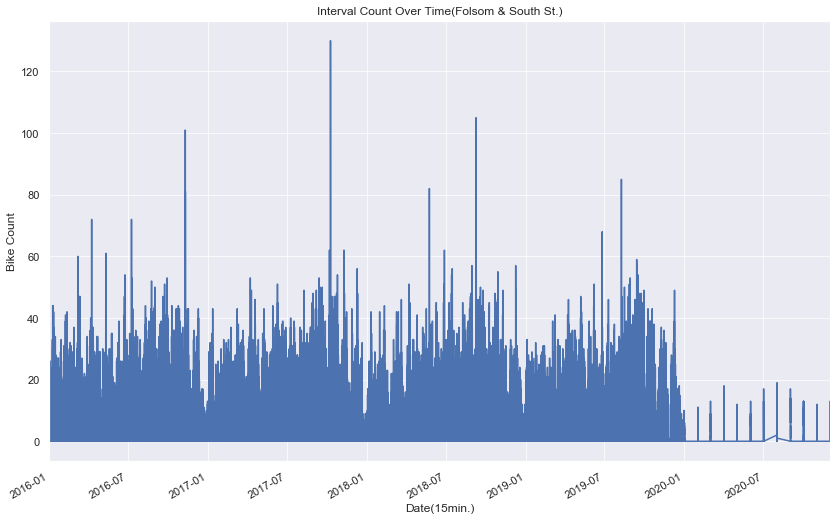

In [12]:
df_folsom_south['total'].plot()

plt.title('Interval Count Over Time(Folsom & South St.)')
plt.xlabel('Date(15min.)')
plt.ylabel('Bike Count')

Text(37.03160000000001, 0.5, 'Bike Count')

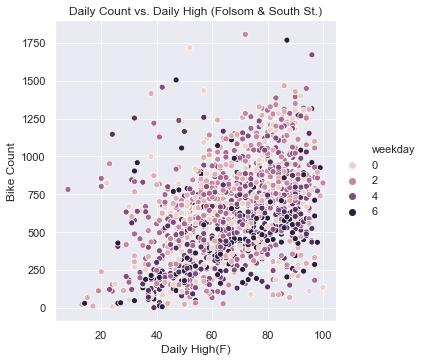

In [13]:
sns.relplot(x='tmax', y='total', hue='weekday', data=days_FS)

plt.title('Daily Count vs. Daily High (Folsom & South St.)')
plt.xlabel('Daily High(F)')
plt.ylabel('Bike Count')

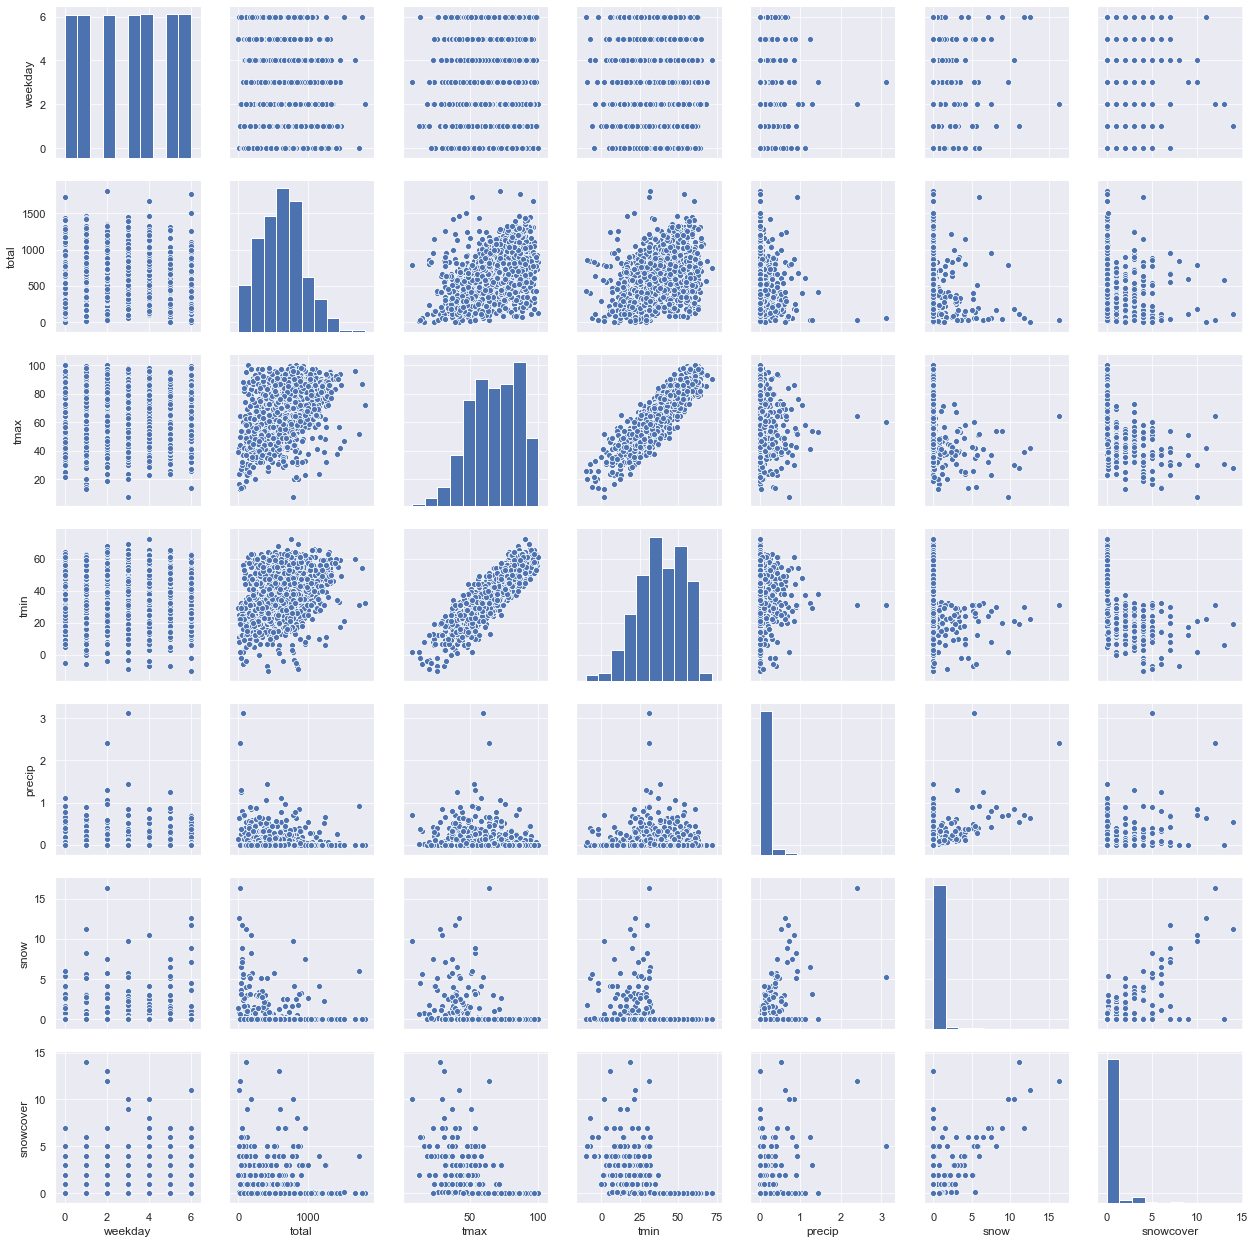

In [14]:
sns.pairplot(data=days_FS)

### ACF/PACF

In [15]:
# Daily Count ACF/PACF
# Each step is 1 day
nlags=60

acf_results = acf(days_FS['total'], nlags=nlags)
pacf_results = pacf(days_FS['total'], nlags=nlags)

C:\Users\munoz\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


In [16]:
# When using df_folsom_south the interval of data is 15 minutes
# There are 96 steps in a 24 hour period
nlags2=288

acf_results_2 = acf(df_folsom_south['total'], nlags=nlags2)
pacf_results_2 = pacf(df_folsom_south['total'], nlags=nlags2)

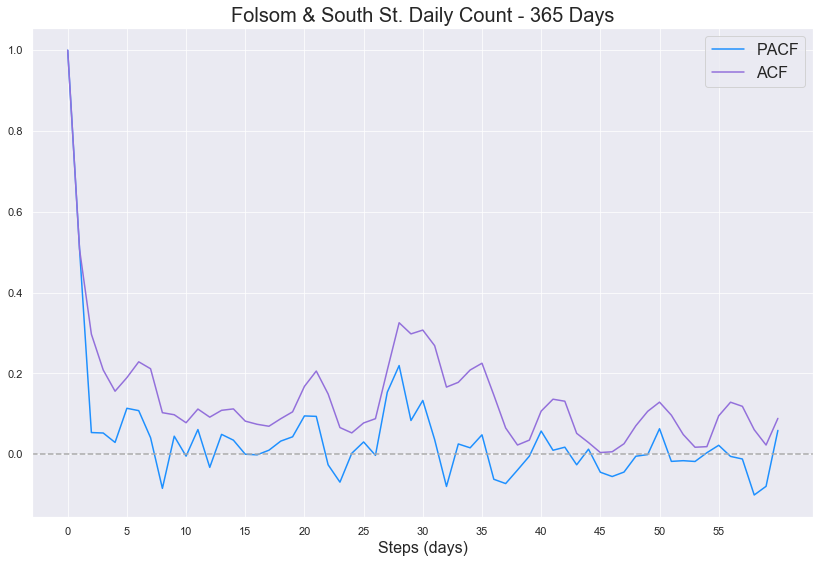

In [17]:
xtick_int = 5

plt.plot(pacf_results, color=colors[5], label='PACF')
plt.plot(acf_results, color=colors[6], label='ACF')

plt.xticks(np.arange(0, nlags, xtick_int))
plt.axhline(y=0, linestyle='--', color='darkgray')


plt.title('Folsom & South St. Daily Count - 365 Days', fontsize=20)
plt.xlabel('Steps (days)', fontsize=16)
plt.legend(loc='upper right', fontsize=16)

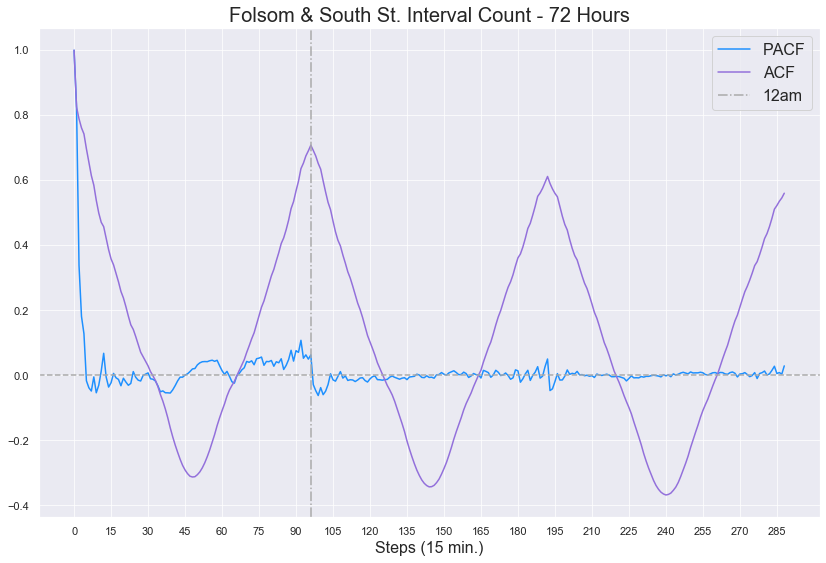

In [18]:
xtick_int2 = 15

plt.plot(pacf_results_2, color=colors[5], label='PACF')
plt.plot(acf_results_2, color=colors[6], label='ACF')

plt.xticks(np.arange(0, nlags2, xtick_int2))
plt.axhline(y=0, linestyle='--', color='darkgray')
plt.axvline(x=96, linestyle='-.', color='darkgray', label='12am')

plt.title('Folsom & South St. Interval Count - 72 Hours', fontsize=20)
plt.xlabel('Steps (15 min.)', fontsize=16)
plt.legend(loc='upper right', fontsize=16)

In [19]:
zeros = df_folsom_south['total'].value_counts()[0] / len(df_folsom_south['total'])
print("The count of '0' is {:.4}% of the counts.".format(zeros *100))

The count of '0' is 26.45% of the counts.


Let's look at grouping by hour instead (4 steps)

In [20]:
hours_FS = df_folsom_south.groupby([pd.Grouper(freq='H')])['total'].sum()
hours_FS = pd.DataFrame(data=hours_FS)
hours_FS.head()

,total
date,
2016-01-01 00:00:00,0
2016-01-01 01:00:00,1
2016-01-01 02:00:00,1
2016-01-01 03:00:00,0
2016-01-01 04:00:00,0


In [21]:
zeros = hours_FS['total'].value_counts()[0] / len(hours_FS['total'])
print("The count of '0' is {:.4}% of the hourly counts.".format(zeros *100))

The count of '0' is 27.73% of the hourly counts.


In [22]:
# When using hours_FS the interval of data is 1 hour
# There are 24steps in a 24 hour period
nlags3=120

acf_results_3 = acf(hours_FS['total'], nlags=nlags3)
pacf_results_3 = pacf(hours_FS['total'], nlags=nlags3)

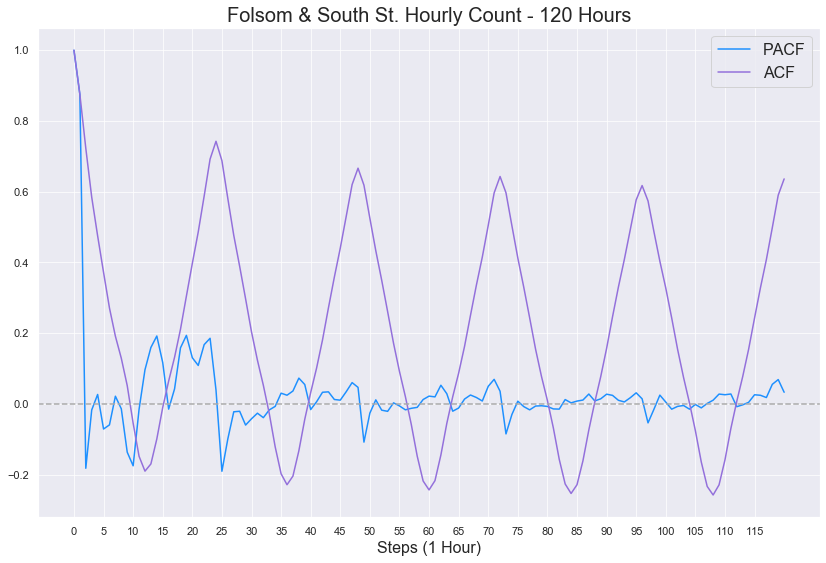

In [23]:
xtick_int3 = 5

plt.plot(pacf_results_3, color=colors[5], label='PACF')
plt.plot(acf_results_3, color=colors[6], label='ACF')

plt.xticks(np.arange(0, nlags3, xtick_int3))
plt.axhline(y=0, linestyle='--', color='darkgray')

plt.title('Folsom & South St. Hourly Count - 120 Hours', fontsize=20)
plt.xlabel('Steps (1 Hour)', fontsize=16)
plt.legend(loc='upper right', fontsize=16)

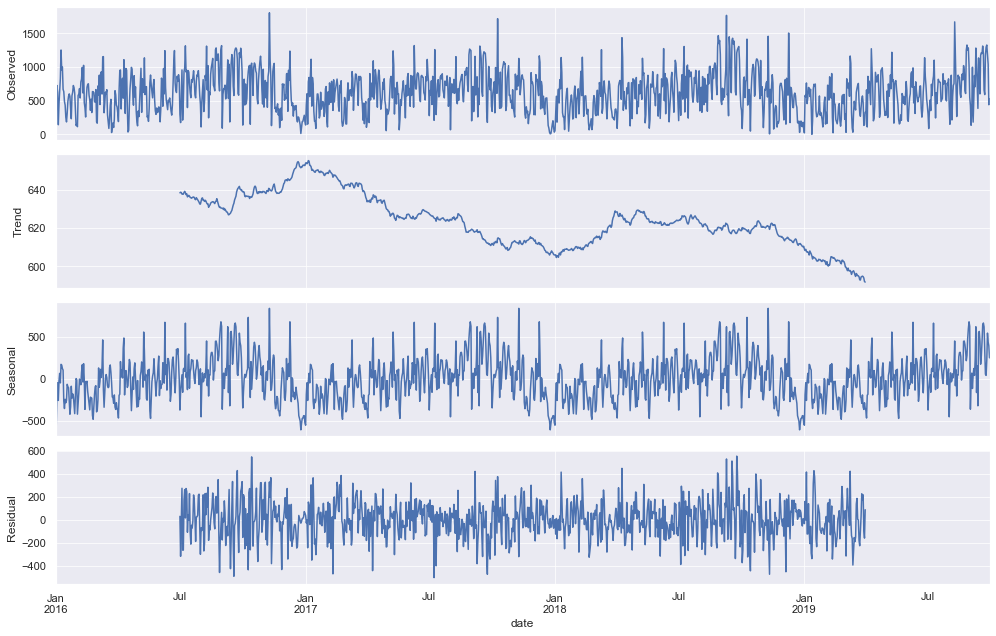

In [24]:
results = sm.tsa.seasonal_decompose(days_FS['total'], freq=365)
plot = results.plot()

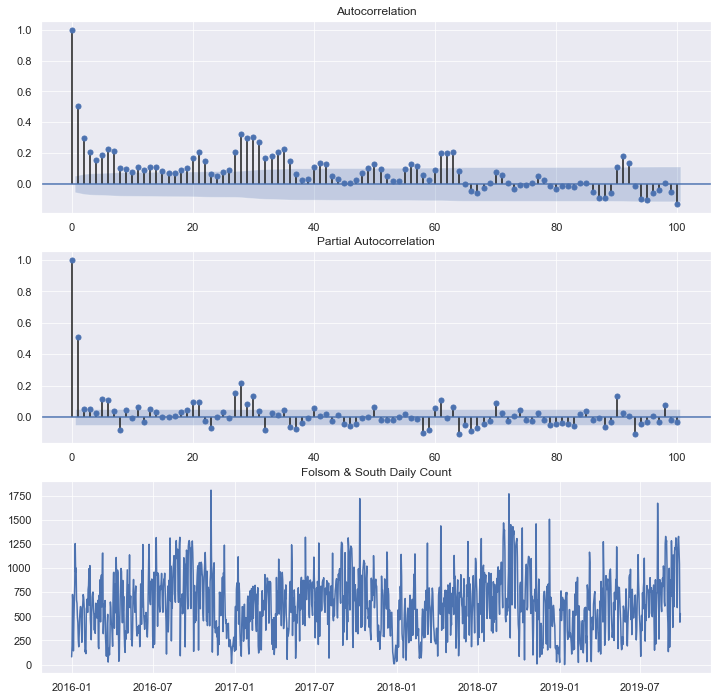

In [25]:
lags=100

fig, ax = plt.subplots(3, figsize=(12,12))

ax[0] = plot_acf(days_FS['total'], ax=ax[0], lags=lags)
ax[1] = plot_pacf(days_FS['total'], ax=ax[1], lags=lags)
ax[2] = plt.plot(days_FS['total'])

plt.title('Folsom & South Daily Count')
plt.show()

something happnens every 30 days - something to do with months?
lagging - look at last 2-3 days for next day (snowfall/lowtemps in previous days)
length of day feature

C:\Users\munoz\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


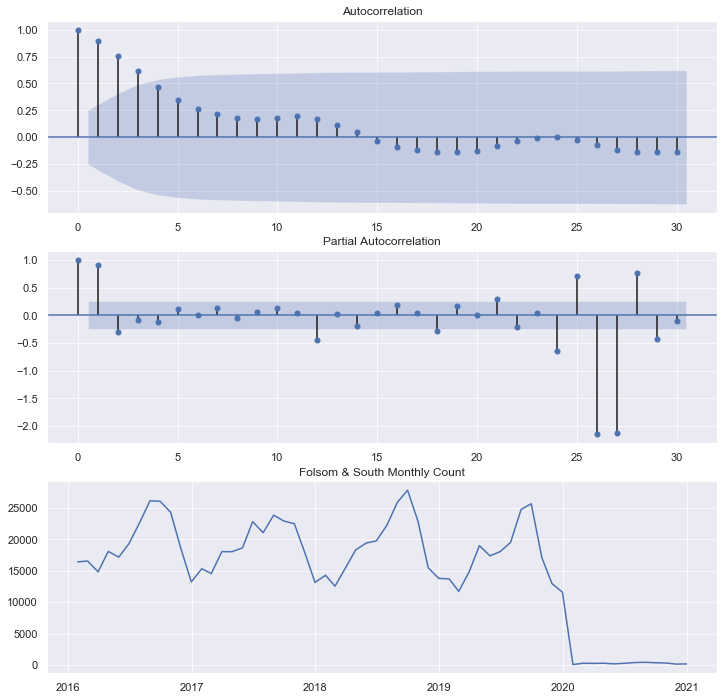

In [26]:
lags=30

fig, ax = plt.subplots(3, figsize=(12,12))

ax[0] = plot_acf(months_folsom_south['total'], ax=ax[0], lags=lags)
ax[1] = plot_pacf(months_folsom_south['total'], ax=ax[1], lags=lags)
ax[2] = plt.plot(months_folsom_south['total'])

plt.title('Folsom & South Monthly Count')
plt.show()

## FB Prohphet Forecasting

In [27]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


### Daily Forecasting

TypeError: float() argument must be a string or a number, not 'Period'

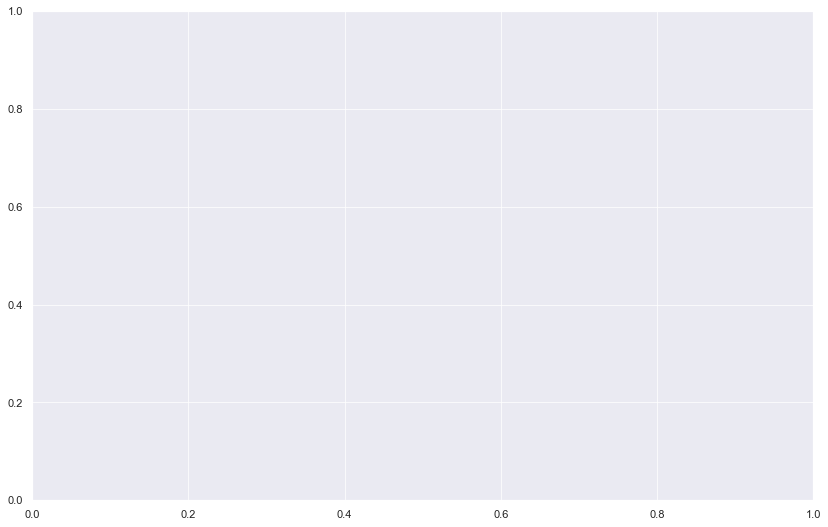

In [31]:
days_FS_prophet = days_FS

days_FS_prophet['ds'] = days_FS_prophet.index
days_FS_prophet = days_FS_prophet.drop(columns=['weekday','tmax','tmin','precip','snow','snowcover'])
days_FS_prophet.columns = ['y', 'ds']

days_FS_prophet['ds'] = pd.to_datetime(days_FS_prophet['ds'])

days_2018 = days_FS_prophet[days_FS_prophet['ds'].dt.year == 2018]

days_FS_prophet['y'].plot()
days_2018['y'].plot()

In [32]:
model = Prophet(daily_seasonality=False,
               weekly_seasonality=True,
               yearly_seasonality=True).fit(days_FS_prophet)

model_2018 = Prophet(daily_seasonality= False,
                    weekly_seasonality=True,
                    yearly_seasonality=True).fit(days_2018)

In [33]:
future = model.make_future_dataframe(periods=365, freq='d')
future_2018 = model_2018.make_future_dataframe(periods=180, freq='d')

In [34]:
forecast = model.predict(future)
forecast_2018 = model_2018.predict(future_2018)

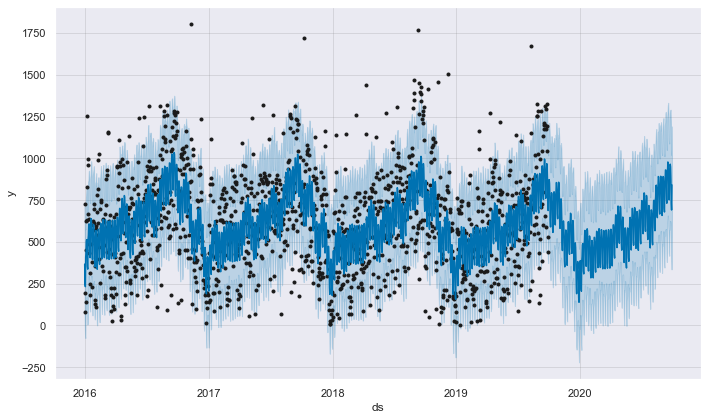

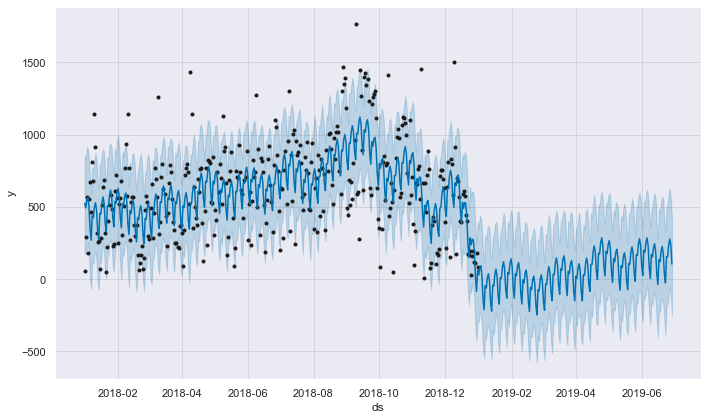

In [35]:
fig1 = model.plot(forecast)
fig2 = model_2018.plot(forecast_2018)

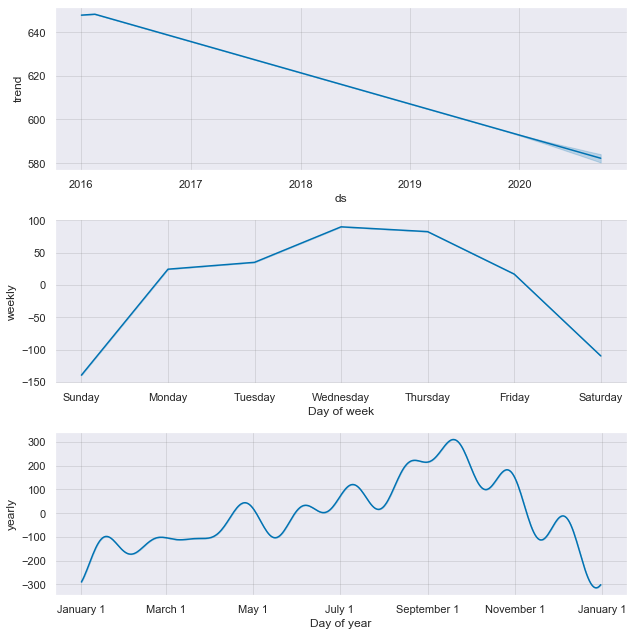

In [36]:
fig2 = model.plot_components(forecast)

### Hourly Forecasting

In [37]:
hours_FS_prophet = hours_FS

hours_FS_prophet['ds'] = hours_FS_prophet.index
hours_FS_prophet['ds'] = pd.to_datetime(hours_FS_prophet['ds'])
hours_FS_prophet.columns = ['y', 'ds']

# hours_FS_prophet = hours_FS_prophet[hours_FS_prophet['ds'].dt.year < 2019]

hours_FS_prophet.tail()

,y,ds
date,,
2020-12-01 19:00:00,7,2020-12-01 19:00:00
2020-12-01 20:00:00,3,2020-12-01 20:00:00
2020-12-01 21:00:00,8,2020-12-01 21:00:00
2020-12-01 22:00:00,2,2020-12-01 22:00:00
2020-12-01 23:00:00,3,2020-12-01 23:00:00


In [380]:
# Slice the dataset to only a few(3) days for predicting next few hours
start = 1
end = 7
month = 8
year = 2019
fit = hours_FS_prophet[((hours_FS_prophet['ds'].dt.year == year) & (hours_FS_prophet['ds'].dt.month == month) & (hours_FS_prophet['ds'].dt.day >= start) & (hours_FS_prophet['ds'].dt.day <= end))]

# Logistic growth floor and cap to prevent sub 0 predictions
# Max hourly value observed is 286, 10th largest is 207
floor = 0
cap = 300
fit['floor'] = floor
fit['cap'] = cap

model_hourly =  Prophet(growth='logistic',
                        daily_seasonality=True, 
                        weekly_seasonality=True, 
                        yearly_seasonality=False).fit(fit)

C:\Users\munoz\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\munoz\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [381]:
future_hourly = model_hourly.make_future_dataframe(periods=24, freq='H')

future_hourly['floor'] = floor
future_hourly['cap'] = cap
future_hourly

,ds,floor,cap
0,2019-08-01 00:00:00,0,300
1,2019-08-01 01:00:00,0,300
2,2019-08-01 02:00:00,0,300
3,2019-08-01 03:00:00,0,300
4,2019-08-01 04:00:00,0,300
...,...,...,...
187,2019-08-08 19:00:00,0,300
188,2019-08-08 20:00:00,0,300
189,2019-08-08 21:00:00,0,300
190,2019-08-08 22:00:00,0,300


In [382]:
forecast_hourly = model_hourly.predict(future_hourly)
forecast_hourly[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
187,2019-08-08 19:00:00,18.915291,3.627054,33.114544
188,2019-08-08 20:00:00,9.260901,-5.826516,23.204697
189,2019-08-08 21:00:00,2.470251,-12.520031,17.780051
190,2019-08-08 22:00:00,-1.493767,-16.307001,13.311533
191,2019-08-08 23:00:00,-3.562440,-19.067111,11.137490


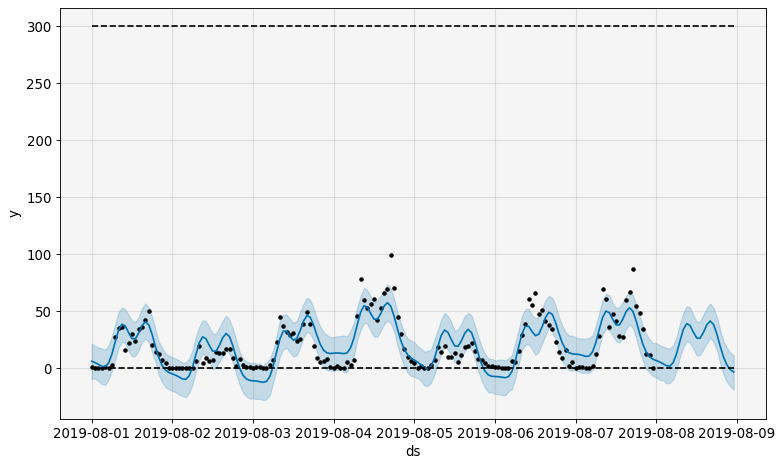

In [383]:
fig3 = model_hourly.plot(forecast_hourly)

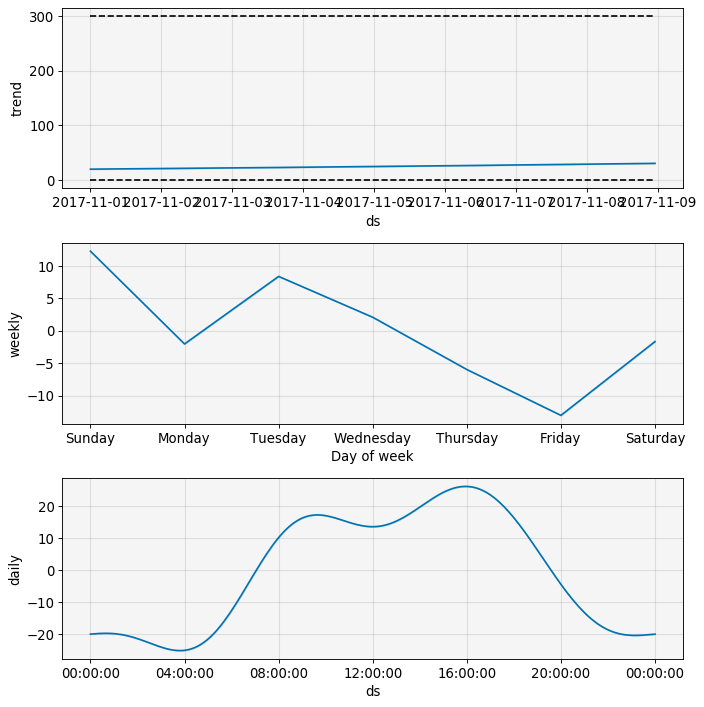

In [340]:
fig4 = model_hourly.plot_components(forecast_hourly)

### Monthly Forecasting

In [19]:
months_FS_prophet = months_folsom_south
months_FS_prophet['ds'] = months_FS_prophet.index
months_FS_prophet.columns = ['y', 'ds']
months_FS_prophet['ds'] = pd.to_datetime(months_FS_prophet['ds'])

# Drop incomplete months
months_FS_prophet.drop(months_FS_prophet.tail(2).index, inplace=True)
# months_FS_prophet = months_FS_prophet[months_FS_prophet['ds'].dt.year < 2019]
months_FS_prophet.tail()

,y,ds
date,,
2019-06-30,17013,2019-06-30
2019-07-31,18685,2019-07-31
2019-08-31,22622,2019-08-31
2019-09-30,23497,2019-09-30
2019-10-31,4915,2019-10-31


In [22]:
model_monthly = Prophet(daily_seasonality=False,
               weekly_seasonality=False,
               yearly_seasonality=True).fit(months_FS_prophet)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [29]:
future_monthly = model_monthly.make_future_dataframe(periods=12, freq='M')

In [30]:
forecast_monthly = model_monthly.predict(future_monthly)
forecast_monthly[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
53,2020-06-30,16162.156461,13978.318817,18283.986677
54,2020-07-31,17015.903145,14837.991774,19054.993134
55,2020-08-31,19477.212777,17248.456249,21557.559475
56,2020-09-30,18496.088707,16214.801404,20647.814715
57,2020-10-31,20066.556741,17897.753100,22249.083532


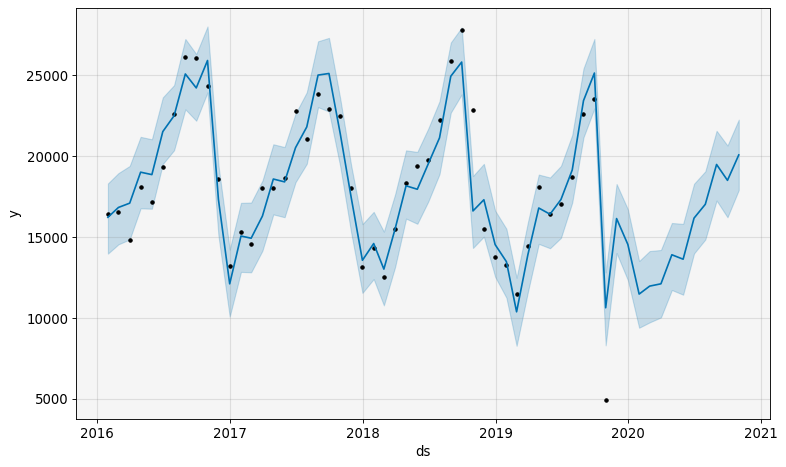

In [31]:
fig5 = model_monthly.plot(forecast_monthly)

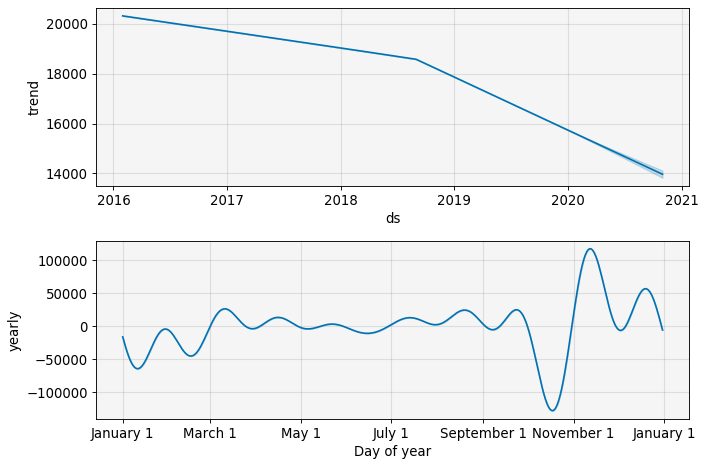

In [32]:
fig6 = model_monthly.plot_components(forecast_monthly)

In [33]:
monthly_cv = cross_validation(model_monthly, initial=pd.to_timedelta(12,unit='M'), horizon=pd.to_timedelta(12, unit='M'))

INFO:fbprophet:Making 4 forecasts with cutoffs between 2017-04-30 21:27:00 and 2018-10-30 18:10:48
INFO:fbprophet:n_changepoints greater than number of observations.Using 11.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:n_changepoints greater than number of observations.Using 21.


In [34]:
monthly_cv.head(50)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-05-31,26423.333571,26423.333545,26423.333594,18638,2017-04-30 21:27:00
1,2017-06-30,16089.209115,16089.209030,16089.209195,22798,2017-04-30 21:27:00
2,2017-07-31,31825.002758,31825.002579,31825.002917,21052,2017-04-30 21:27:00
3,2017-08-31,24881.264582,24881.264300,24881.264834,23837,2017-04-30 21:27:00
4,2017-09-30,27533.252446,27533.252041,27533.252792,22904,2017-04-30 21:27:00
5,2017-10-31,25138.938443,25138.937871,25138.938910,22470,2017-04-30 21:27:00
6,2017-11-30,22000.410301,22000.409599,22000.410895,18013,2017-04-30 21:27:00
7,2017-12-31,19814.498815,19814.497973,19814.499532,13152,2017-04-30 21:27:00
8,2018-01-31,19209.279404,19209.278391,19209.280247,14287,2017-04-30 21:27:00
9,2018-02-28,12542.680301,12542.679138,12542.681295,12551,2017-04-30 21:27:00


In [35]:
monthly_p = performance_metrics(monthly_cv)
monthly_p.head(50)

,horizon,mse,rmse,mae,mape,coverage
0,30 days 02:33:00,1.968468e+08,14030.210272,9594.064825,0.448521,0.00
1,30 days 05:49:12,1.991599e+08,14112.400971,10067.525034,0.486900,0.00
2,30 days 11:38:24,2.038599e+07,4515.085104,3878.950119,0.217174,0.00
3,59 days 20:43:48,2.463603e+07,4963.469720,4487.593866,0.247469,0.00
4,60 days 02:33:00,2.073515e+07,4553.586031,4218.458194,0.216609,0.00
5,61 days 05:49:12,1.811826e+07,4256.554617,3623.796138,0.180180,0.25
6,61 days 11:38:24,1.758162e+07,4193.043987,3471.530655,0.179204,0.25
7,90 days 20:43:48,1.474952e+07,3840.510649,3117.590067,0.156636,0.25
8,91 days 02:33:00,3.251195e+07,5701.925146,4133.643035,0.211001,0.25
9,92 days 05:49:12,3.375028e+07,5809.499381,4492.012696,0.238674,0.00


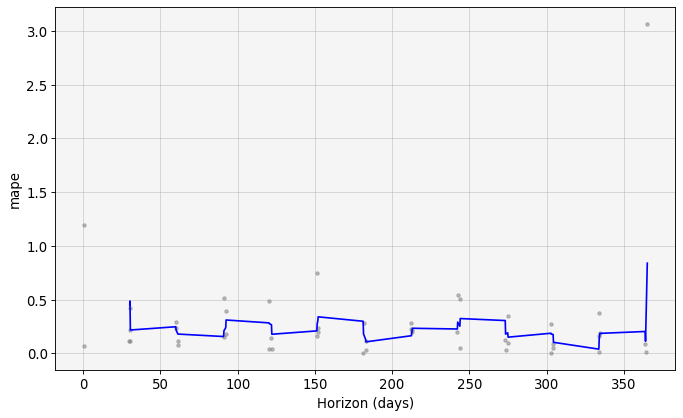

In [36]:
fig = plot_cross_validation_metric(monthly_cv, metric='mape')

### Weekly Forecasting

In [37]:
weeks_FS_prophet = weeks_folsom_south
weeks_FS_prophet['ds'] = weeks_FS_prophet.index
weeks_FS_prophet.columns = ['y', 'ds']
weeks_FS_prophet['ds'] = pd.to_datetime(weeks_FS_prophet['ds'])

weeks_FS_prophet = weeks_FS_prophet[weeks_FS_prophet['ds'].dt.year < 2019]
weeks_FS_prophet.tail()

,y,ds
date,,
2018-12-03,4091,2018-12-03
2018-12-10,5599,2018-12-10
2018-12-17,3498,2018-12-17
2018-12-24,2565,2018-12-24
2018-12-31,879,2018-12-31


In [38]:
0 in weeks_FS_prophet['y'].values

False

In [39]:
model_weekly = Prophet(daily_seasonality=False,
                      weekly_seasonality=False,
                      yearly_seasonality=True).fit(weeks_FS_prophet)

In [40]:
future_weekly = model_weekly.make_future_dataframe(periods=52, freq='7d')

In [41]:
forecast_weekly = model_weekly.predict(future_weekly)
forecast_weekly[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
204,2019-12-02,4068.750869,2915.789650,5235.110355
205,2019-12-09,4260.219215,3123.533867,5422.127211
206,2019-12-16,3659.477463,2457.639608,4833.200579
207,2019-12-23,2590.589810,1363.540491,3714.656459
208,2019-12-30,1919.970809,751.117184,3027.937596


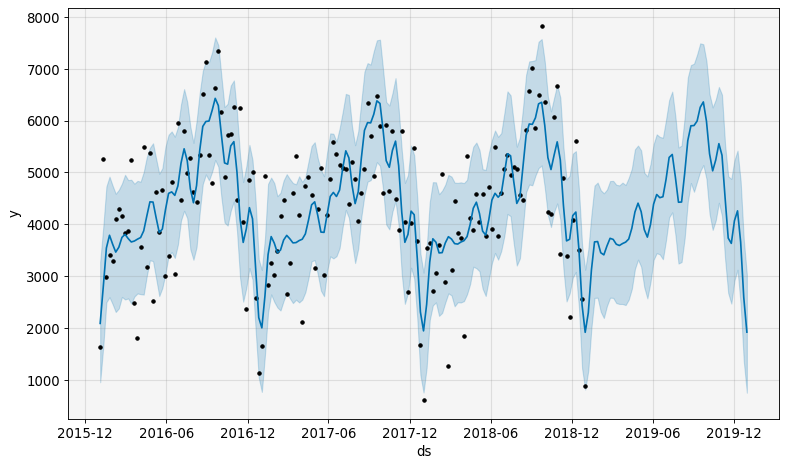

In [42]:
fig7 = model_weekly.plot(forecast_weekly)

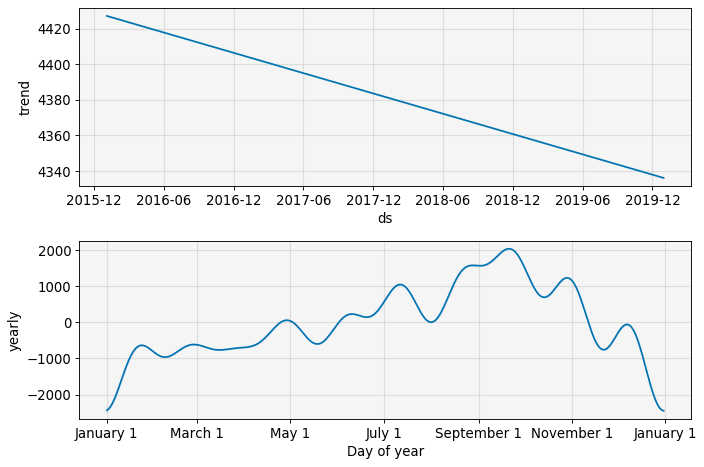

In [43]:
fig8 = model_weekly.plot_components(forecast_weekly)